In [9]:
import xarray as xr
import numpy as np
import glob
import pandas as pd

In [117]:
import matplotlib.pyplot as plt

In [133]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
import geopandas as gpd
from shapely.geometry import *

### label gridcells by biome

In [5]:
def byhand(t,p):
    t1 = -5  #    tundra-boreal
    t2 =  3  #    boreal-temperate
    t3 = 20  # temperate-tropical

    tvals = [-np.inf,t1,t2,t3,np.inf]
    bvals = [9,8,4,1]


    for i in range(4):
        if (t>tvals[i])&(t<=tvals[i+1]):
            b = bvals[i]

    td = 15; pd=60; bd=3  #desert
    if (t>td)&(p<pd):
        b = bd

    return b

In [29]:
fp = './whit/Whittaker_biomes.shp'
data = gpd.read_file(fp)
og   = data.biome_id.copy(deep=True).values
df = pd.read_csv('./whit/Whittaker_biomes.csv')

In [30]:
#reassigning biome ids to a more logical order
newb = np.array([9,8,7,6,5,4,1,2,3])
data.biome_id=newb #more logical order
x  = df.biome_id.values 
df0=df.copy(deep=True)
for i in 1+np.arange(9):
    ix = df0.biome_id==i
    b  = newb[og==i]
    x[ix]=b
df.biome_id=x

In [155]:
cfile='/glade/u/home/djk2120/ctsm6_ppe/biomes/crujra_climo.nc'
climo=xr.open_dataset(cfile)

In [40]:
bclass=0*climo.RAIN+np.nan
bclass.name='BIOME'

In [65]:
tbot=climo.TBOT-273.15 #degC
gpp=climo.GPP #gC/m2/s
prec=climo.PREC*24*60*60*365/10 #cm/yr

In [76]:
nlat=len(climo.lat)
nlon=len(climo.lon)
ivals=np.tile(np.arange(nlat),[nlon,1]).T
jvals=np.tile(np.arange(nlon),[nlat,1])

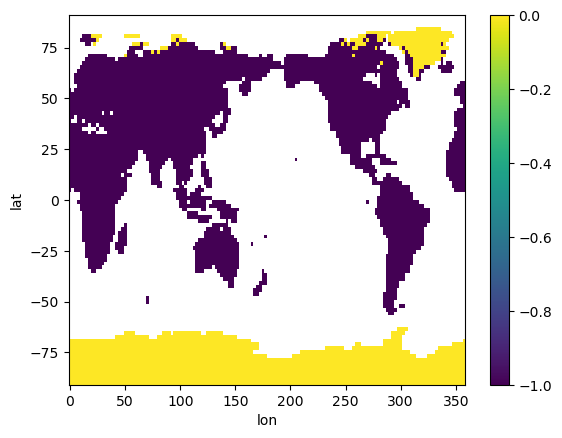

In [85]:
bclass=((tbot<0)&(gpp==0)).where(~np.isnan(tbot))-1
bclass.plot()

In [86]:
ix=bclass==-1

In [114]:
for i,j in zip(ivals[ix],jvals[ix]):
    ptf = gpd.GeoDataFrame({'geometry':[Point(tbot[i,j],prec[i,j])]})
    x=gpd.overlay(ptf, data, how='intersection')
    if len(x)>0:
        bclass[i,j] = x.biome_id.values[0]
    else:
        bclass[i,j] = byhand(tbot[i,j],prec[i,j])

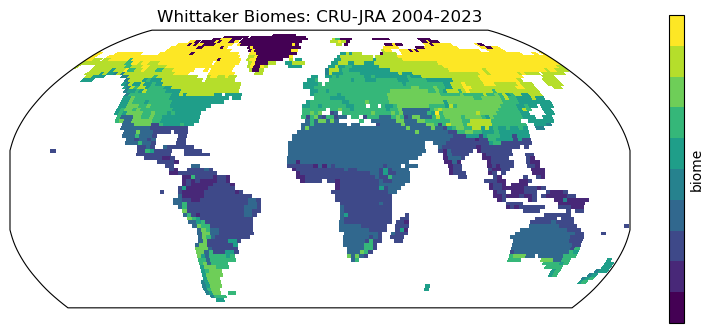

In [139]:
fig= plt.figure(figsize=[10,4])
ax = fig.add_subplot(111,projection=ccrs.Robinson()) # first row, first col
extent = [-180, 180,-60,90]
ax.set_extent(extent, crs=ccrs.PlateCarree())
cmap=plt.get_cmap('viridis',10)
bclass.plot(cmap=cmap,vmin=0,vmax=9,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={'label':'biome','ticks':[]})
plt.title('Whittaker Biomes: CRU-JRA 2004-2023');
plt.savefig('whittaker_fullgrid_map.png',dpi=300,bbox_inches='tight')

In [140]:
dsout=xr.Dataset()
dsout['biome_fg']=bclass

In [152]:
bnames=['Ice Sheet']
for i in 1+np.arange(9):
    bnames.append(data.biome[data.biome_id==i].values[0])
dsout['biome_name']=xr.DataArray(bnames,dims='biome_id')

In [159]:
dsout.attrs={'script':'/glade/u/home/djk2120/ctsm6_ppe/biomes/whittaker.ipynb',
             'climo':cfile,
             'case':'/glade/derecho/scratch/slevis/archive/ctsm53017_f19_BNF_hist/lnd/hist/'}
dsout.to_netcdf('whit/whitkey.nc')

### compute T/P climatologies

In [51]:
def preprocess(ds):
    dvs=['TBOT','RAIN','SNOW','GPP']
    return ds[dvs]

In [ ]:
#load data
d='/glade/derecho/scratch/slevis/archive/ctsm53017_f19_BNF_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h0*'))
ds = xr.open_mfdataset(files[-240:],combine='by_coords',preprocess=preprocess)
yr0=str(ds['time.year'][0].values)
ds['time']=xr.cftime_range(yr0,periods=len(ds.time),freq='MS',calendar='noleap') #fix time

In [55]:
#compute climo
dpm=ds['time.daysinmonth']
dsout=ds.weighted(dpm).mean(dim='time').compute()
dsout['PREC']=dsout['RAIN']+dsout['SNOW']

In [56]:
#label data and write to disk
for v in ds.data_vars:
    dsout[v].attrs=ds[v].attrs
dsout['PREC'].attrs={'long_name':'Precipitation',
                     'units':ds.RAIN.attrs['units'],
                     'note':'RAIN+SNOW'}
tstr=(str(ds['time.year'].min().values)+'-'+
      str(ds['time.year'].max().values)+' climatologies')
dsout.attrs={'case':d,
             'script':'/glade/u/home/djk2120/ctsm6_ppe/biomes/whittaker.ipynb',
             'note':tstr}
dsout.to_netcdf('crujra_climo.nc')

In [57]:
dsout

<xarray.Dataset>
Dimensions:  (lon: 144, lat: 96)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Data variables:
    TBOT     (lat, lon) float64 239.8 239.8 239.8 239.6 ... nan nan nan nan
    RAIN     (lat, lon) float64 5.566e-09 5.559e-09 5.542e-09 ... nan nan nan
    SNOW     (lat, lon) float64 2.495e-06 2.495e-06 2.495e-06 ... nan nan nan
    GPP      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    PREC     (lat, lon) float64 2.5e-06 2.5e-06 2.5e-06 2.5e-06 ... nan nan nan
Attributes:
    case:     /glade/derecho/scratch/slevis/archive/ctsm53017_f19_BNF_hist/ln...
    script:   /glade/u/home/djk2120/ctsm6_ppe/biomes/whittaker.ipynb
    note:     2004-2023 climatologies

'2004-2024 climatologies'

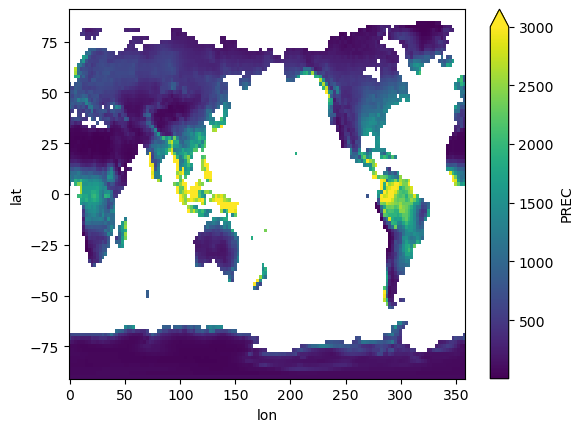